#  Homework 5 - Berkeley STAT 157

**Your name: Zhiming, SID 3034485754** (Please add your name, and SID to ease Ryan and Rachel to grade.)

**Please submit your homework through [gradescope](http://gradescope.com/) instead of Github, so you will get the score distribution for each question. Please enroll in the [class](https://www.gradescope.com/courses/42432) by the Entry code: MXG5G5** 

Handout 2/19/2019, due 2/26/2019 by 4pm in Git by committing to your repository.

In this homework, we will model covariate shift and attempt to fix it using logistic regression. This is a fairly realistic scenario for data scientists. To keep things well under control and understandable we will use [Fashion-MNIST](http://d2l.ai/chapter_linear-networks/fashion-mnist.html) as the data to experiment on. 

Follow the instructions from the Fashion MNIST notebook to get the data.

In [2]:
%matplotlib inline
from mxnet import autograd, gluon, init, nd
from mxnet.gluon import data as gdata, loss as gloss, nn, utils
import d2l
import numpy as np
import matplotlib.pyplot as plt
import mxnet as mx
import time

## 1. Logistic Regression

1. Implement the logistic loss function $l(y,f) = -\log(1 + \exp(-y f))$ in Gluon.
2. Plot its values and its derivative for $y = 1$ and $f \in [-5, 5]$, using automatic differentiation in Gluon.
3. Generate training and test datasets for a binary classification problem using Fashion-MNIST with class $1$ being a combination of `shirt` and `sweater` and class $-1$ being the combination of `sandal` and `sneaker` categories. 
4. Train a binary classifier of your choice (it can be linear or a simple MLP such as from a previous lecture) using half the data (i.e. $12,000$ observations mixed as abvove) and one using the full dataset (i.e. $24,000$ observations as arising from the 4 categories) and report its accuracy. 

Hint - you should encapsulate the training and reporting code in a callable function since you'll need it quite a bit in the following. 

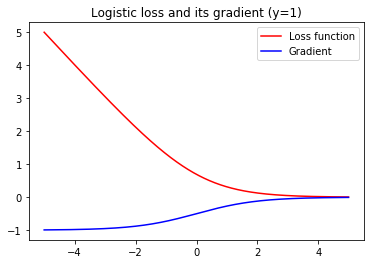

In [4]:
# for question 1 & 2
def logistic_loss(f, y):
    l = nd.log(1.0+nd.exp(-f*y))
    return l
f = nd.arange(-5, 5, 0.01)
f.attach_grad()
# for y = 1
y = nd.ones(shape = f.shape)
with autograd.record():
    l = logistic_loss(f, y)
l.backward()
# for loss function
plt.figure()
plt.title('Logistic loss and its gradient (y=1)')
plt.plot(f.asnumpy(), l.asnumpy(), color = 'r',\
         label = 'Loss function')
# for grad
plt.plot(f.asnumpy(), f.grad.asnumpy(), color = 'b',\
        label = 'Gradient')
plt.legend(loc = 'upper right')
plt.show()

In [9]:
mnist_train = gdata.vision.FashionMNIST(train=True, transform = lambda data, label:\
                                        (data.astype(np.float32), label))
mnist_test = gdata.vision.FashionMNIST(train=False, transform = lambda data, label:\
                                        (data.astype(np.float32), label))

In [13]:
# for question 3
#X, y = train[0:9]
# pick out pullover/shirt, and sneaker/scandal
# a new preprocess function, can produce biased dataset
def preprocess(mnist_train, mnist_test, total_per_label, ratio): # ratio is the lambda above
    X, y = mnist_train[:]
    # pick up the indices
    index_sweater = np.where(y==3)[0]
    index_shirt = np.where(y==6)[0]
    index_scandal = np.where(y==5)[0]
    index_sneaker = np.where(y==7)[0]
    # create the class for training, biased
    class_sweater = X[index_sweater[0:round(total_per_label*ratio)]]
    class_shirt = X[index_shirt[0:round(total_per_label*ratio)]]
    class_scandal = X[index_scandal[0:round(total_per_label*(1-ratio))]]
    class_sneaker = X[index_sneaker[0:round(total_per_label*(1-ratio))]]
    # print(class_sweater.shape, class_shirt.shape, class_scandal.shape, class_sneaker.shape)
    train_feature = nd.concat(class_sweater, class_shirt, class_scandal, class_sneaker, dim=0)
    label1 = nd.ones((1, total_per_label)).astype(np.float32)
    label2 = nd.zeros((1, total_per_label)).astype(np.float32)
    train_labels = nd.concat(label1, label2, dim=1).reshape(shape=(-1,))
    train_data = gdata.dataset.ArrayDataset(train_feature, train_labels)
    # create the class for testing, unbiased
    X, y = mnist_test[:]
    index1 = np.where(np.logical_or(y==3, y==6))[0]
    index2 = np.where(np.logical_or(y==5, y==7))[0]
    class1 = X[index1]
    class2 = X[index2]
    test_feature = nd.concat(class1, class2, dim=0)
    
    label1 = nd.ones((1, 2000)).astype(np.float32)
    label2 = nd.zeros((1, 2000)).astype(np.float32)
    test_labels = nd.concat(label1, label2, dim=1).reshape(shape=(-1,))
    test_data = gdata.dataset.ArrayDataset(test_feature, test_labels)
    
    return train_data, test_data

In [14]:
def train_and_test_mnist(train_data, test_data, batch_size, lr, num_epochs):
    net = nn.Sequential()
    net.add(nn.Dense(2))
    net.initialize(init.Normal(sigma=0.01))
    loss = gluon.loss.SoftmaxCrossEntropyLoss()
    #loss = logistic_loss
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr})
    d2l.train_ch3(net, train_data, test_data, loss, num_epochs, batch_size, None, None, trainer)

In [15]:
# half the dataset 
# note: use half the dataset, test acc is almost the same as using the full dataset
# so I used just 50 per label for train (total 100 for training), which leads to
# observable difference in test acc (~.975 v.s. ~.999)
train_data, test_data = preprocess(mnist_train, mnist_test, total_per_label=50, ratio=0.5) # ratio=.5 for equally division
batch_size = 64
train_data = gluon.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_data = gluon.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
train_and_test_mnist(train_data, test_data, batch_size=batch_size, lr=0.1, num_epochs=5)
# full dataset
train_data, test_data = preprocess(mnist_train, mnist_test, total_per_label=12000, ratio=0.5) # ration=.5 for equally division
batch_size = 64
train_data = gluon.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_data = gluon.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
train_and_test_mnist(train_data, test_data, batch_size=batch_size, lr=0.1, num_epochs=5)

epoch 1, loss 42165.6241, train acc 0.370, test acc 0.643
epoch 2, loss 5175.9153, train acc 0.830, test acc 0.955
epoch 3, loss 398.0108, train acc 0.990, test acc 0.958
epoch 4, loss 298.5734, train acc 0.990, test acc 0.961
epoch 5, loss 199.1360, train acc 0.990, test acc 0.964
epoch 1, loss 76.4225, train acc 0.994, test acc 0.999
epoch 2, loss 17.0642, train acc 0.999, test acc 0.999
epoch 3, loss 9.3493, train acc 0.999, test acc 0.999
epoch 4, loss 8.1944, train acc 0.999, test acc 0.998
epoch 5, loss 7.4239, train acc 0.999, test acc 0.999


## 2. Covariate Shift

Your goal is to introduce covariate shit in the data and observe the accuracy. For this, compose a dataset of $12,000$ observations, given by a mixture of `shirt` and `sweater` and of `sandal` and `sneaker` respectively, where you use a fraction $\lambda \in \{0.05, 0.1, 0.2, \ldots 0.8, 0.9, 0.95\}$ of one and a fraction of $1-\lambda$ of  the other datasets respectively. For instance, you might pick for $\lambda = 0.1$ a total of $600$ `shirt` and $600$ `sweater` images and likewise $5,400$ `sandal` and $5,400$ `sneaker` photos, yielding a total of $12,000$ images for training. Note that the test set remains unbiased, composed of $2,000$ photos for the `shirt` + `sweater` category and of the `sandal` + `sneaker` category each.

1. Generate training sets that are appropriately biased. You should have 11 datasets.
2. Train a binary classifier using this and report the test set accuracy on the unbiased test set. 

In [9]:
total_per_label = 6000
num_epochs = 5
print("Bias ratio now is:", .05)
train_data, test_data = preprocess(mnist_train, mnist_test, total_per_label=total_per_label, ratio=0.05)
batch_size = 64
train_data = gluon.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_data = gluon.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
train_and_test_mnist(train_data, test_data, batch_size=batch_size, lr=0.01, num_epochs=num_epochs)
for r in range(1, 9, 1):
    ratio = r / 10.0
    print("Bias ratio now is:", ratio, "(unbiased)" if ratio==.5 else "")
    train_data, test_data = preprocess(mnist_train, mnist_test, total_per_label=total_per_label, ratio=ratio)
    batch_size = 64
    train_data = gluon.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_data = gluon.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
    train_and_test_mnist(train_data, test_data, batch_size=batch_size, lr=0.01, num_epochs=num_epochs)
print("Bias ratio now is:", .95)
train_data, test_data = preprocess(mnist_train, mnist_test, total_per_label=total_per_label, ratio=0.95)
batch_size = 64
train_data = gluon.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_data = gluon.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
train_and_test_mnist(train_data, test_data, batch_size=batch_size, lr=0.01, num_epochs=num_epochs)

Bias ratio now is: 0.05
epoch 1, loss 946.5304, train acc 0.827, test acc 0.742
epoch 2, loss 487.6180, train acc 0.874, test acc 0.767
epoch 3, loss 477.9550, train acc 0.880, test acc 0.763
epoch 4, loss 489.1529, train acc 0.881, test acc 0.797
epoch 5, loss 517.8113, train acc 0.881, test acc 0.795
Bias ratio now is: 0.1 
epoch 1, loss 1050.4910, train acc 0.805, test acc 0.938
epoch 2, loss 761.9554, train acc 0.832, test acc 0.739
epoch 3, loss 689.2948, train acc 0.845, test acc 0.833
epoch 4, loss 649.4030, train acc 0.849, test acc 0.779
epoch 5, loss 635.0590, train acc 0.847, test acc 0.739
Bias ratio now is: 0.2 
epoch 1, loss 1073.4767, train acc 0.777, test acc 0.818
epoch 2, loss 781.6122, train acc 0.802, test acc 0.828
epoch 3, loss 788.6811, train acc 0.800, test acc 0.834
epoch 4, loss 731.6807, train acc 0.813, test acc 0.833
epoch 5, loss 784.2973, train acc 0.809, test acc 0.803
Bias ratio now is: 0.3 
epoch 1, loss 868.0672, train acc 0.790, test acc 0.862
epoch 

## 3. Covariate Shift Correction

Having observed that covariate shift can be harmful, let's try fixing it. For this we first need to compute the appropriate propensity scores $\frac{dp(x)}{dq(x)}$. For this purpose pick a biased dataset, let's say with $\lambda = 0.1$ and try to fix the covariate shift.

1. When training a logistic regression binary classifier to fix covariate shift, we assumed so far that both sets are of equal size. Show that re-weighting data in training and test set appropriately can help address the issue when both datasets have different size. What is the weighting?
    - We can set the weights as $.5/\lambda$ for the class with fraction $\lambda$, and $.5/(1-\lambda)$ for the class with fraction $1-\lambda$.
2. Train a binary classifier (using logistic regression) distinguishing between the biased training set and the unbiased test set. Note - you need to weigh the data. 
3. Use the scores to compute weights on the training set. Do they match the weight arising from the biasing distribution $\lambda$? 
4. Train a binary classifier of the covariate shifted problem using the weights obtained previously and report the accuracy. Note - you will need to modify the training loop slightly such that you can compute the gradient of a weighted sum of losses. 


In [110]:
# a new preprocess procedure, -1/1 for two labels
def preprocess(mnist_train, mnist_test, total_per_label, ratio): # ration is the lambda above
    X, y = mnist_train[:]
    # pick up the indices
    index_sweater = np.where(y==3)[0]
    index_shirt = np.where(y==6)[0]
    index_scandal = np.where(y==5)[0]
    index_sneaker = np.where(y==7)[0]
    # create the class for training, biased
    class_sweater = X[index_sweater[0:round(total_per_label*ratio)]]
    class_shirt = X[index_shirt[0:round(total_per_label*ratio)]]
    class_scandal = X[index_scandal[0:round(total_per_label*(1-ratio))]]
    class_sneaker = X[index_sneaker[0:round(total_per_label*(1-ratio))]]
    # print(class_sweater.shape, class_shirt.shape, class_scandal.shape, class_sneaker.shape)
    train_feature = nd.concat(class_sweater, class_shirt, class_scandal, class_sneaker, dim=0)
    train_feature = nd.flatten(train_feature)
    label1 = nd.ones((1, total_per_label)).astype(np.float32)
    label2 = nd.zeros((1, total_per_label)).astype(np.float32)
    train_labels = nd.concat(label1, label2, dim=1).reshape(shape=(-1,))
    train_data = gdata.dataset.ArrayDataset(train_feature, train_labels)
    # create the class for testing, unbiased
    X, y = mnist_test[:]
    index1 = np.where(np.logical_or(y==3, y==6))[0]
    index2 = np.where(np.logical_or(y==5, y==7))[0]
    class1 = X[index1]
    class2 = X[index2]
    test_feature = nd.concat(class1, class2, dim=0)
    test_feature = nd.flatten(test_feature)
    label1 = nd.ones((1, 2000)).astype(np.float32)
    label2 = nd.zeros((1, 2000)).astype(np.float32)
    test_labels = nd.concat(label1, label2, dim=1).reshape(shape=(-1,))
    test_data = gdata.dataset.ArrayDataset(test_feature, test_labels)
    return train_data, test_data

In [116]:
# preperations
# loss function
def logistic(z):
    return 1. / (1. + nd.exp(-z))
# loss function
def log_loss(output, y, ratio):
    yhat = logistic(output)
    yhat = yhat.reshape(shape=y.shape)
    return  - nd.nansum(.5/ratio * y * nd.log(yhat) + .5/(1-ratio) * (1-y) * nd.log(1-yhat))
# train_model
def train_model(epochs, train_data, net, trainer, batch_size, ratio):
    for e in range(epochs):
        cumulative_loss = 0
        for i, (data, label) in enumerate(train_data):
            with autograd.record():
                output = net(data)
                # print('weigth of net:', net.bias.data(), net.weight.data())
                # print('output of net:', output)
                loss = log_loss(output, label, ratio)
            loss.backward()
            trainer.step(batch_size)
            cumulative_loss += nd.sum(loss).asscalar()
        print("Epoch %s, loss: %s" % (e, cumulative_loss ))
# test_model
def test_model(test_data):
    num_correct = 0.0
    num_total = 0
    for i, (data, label) in enumerate(test_data):
        num_total += len(label)
        output = net(data)
        prediction = ((nd.sign(output).reshape(shape=label.shape) + 1) / 2)
        num_correct += nd.sum(prediction == label)
    print("Accuracy: %0.3f (%s/%s)" % (num_correct.asscalar()/num_total, num_correct.asscalar(), num_total))

In [118]:
def train_and_test_mnist_ratio(train_data, test_data, net, trainer, num_epochs, batch_size, ratio):
    train_data, test_data = preprocess(mnist_train, mnist_test, total_per_label, ratio)
    train_data = gluon.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_data = gluon.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
    train_model(num_epochs, train_data, net, trainer, batch_size, ratio)
    test_model(test_data)

In [ ]:
mnist_train = gdata.vision.FashionMNIST(train=True, transform = lambda data, label:\
                                        (data.astype(np.float32)/255.0, label))
mnist_test = gdata.vision.FashionMNIST(train=False, transform = lambda data, label:\
                                        (data.astype(np.float32)/255.0, label))
train_data, test_data = preprocess(mnist_train, mnist_test, total_per_label, ratio)
train_data = gluon.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_data = gluon.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
net = nn.Dense(1)
net.collect_params().initialize(mx.init.Normal(sigma=.1))
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.03})
batch_size = 128
total_per_label = 6000
ratio = 0.5
num_epochs = 10
train_and_test_mnist_ratio(train_data, test_data, net, trainer, num_epochs, batch_size, ratio)

Epoch 0, loss: 2237.4305810928345
Epoch 1, loss: 805.3088803291321
Epoch 2, loss: 586.0701673030853
Epoch 3, loss: 478.95816826820374
Epoch 4, loss: 412.94981050491333
Epoch 5, loss: 367.19009041786194
Epoch 6, loss: 332.8466372489929
Epoch 7, loss: 306.0613153576851
Epoch 8, loss: 284.4668157696724


### For question 3.2